# Step 1: Load and Explore the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns

In [2]:
import pandas as pd

# Load the dataset
file_path = "/content/final_preprocessed_data.csv"
df = pd.read_csv(file_path, parse_dates=["date"])

# Display the first few rows
df.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,...,lag_7,lag_30,rolling_std_7,lag_1,lag_2,lag_5,lag_10,lag_12,rolling_mean_7,dcoilwtico
0,16323662,2014-01-01,36,106716,3.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16324284,2014-01-01,36,1158720,28.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16352784,2014-01-02,24,106716,2.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,95.14
3,16353829,2014-01-02,24,1158720,20.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,95.14
4,16355696,2014-01-02,26,106716,8.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,95.14


In [3]:
#Sort data by stores and give the top stores by unit sold
df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15)
print(df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15))



store_nbr
28    8744.086807
34    7990.605468
36    5067.843740
35    4631.000000
30    2449.000000
32    1910.605468
24    1089.000000
27    1077.000000
26     884.000000
51     442.000000
Name: unit_sales, dtype: float64


In [4]:
df.shape

(1640, 22)

In [5]:
#Filter the data only fo store number 28
df=df[df['store_nbr']==28]
df.shape

(170, 22)

# Step 2. Build XGBoost model for demand forecasting

## 2.1. Setting up the Environment and Visualising the Data


In [7]:
# Install the xgboost library
!pip install xgboost

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

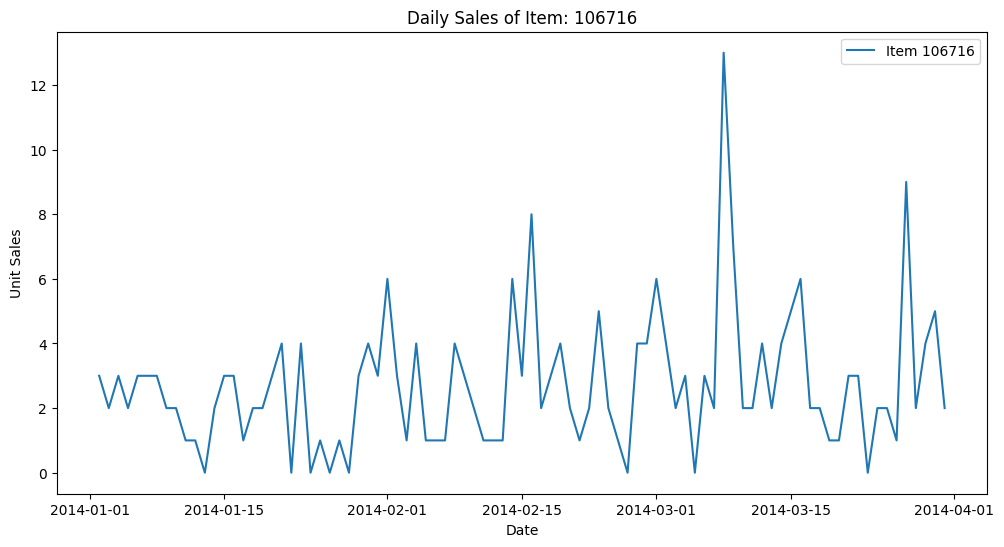

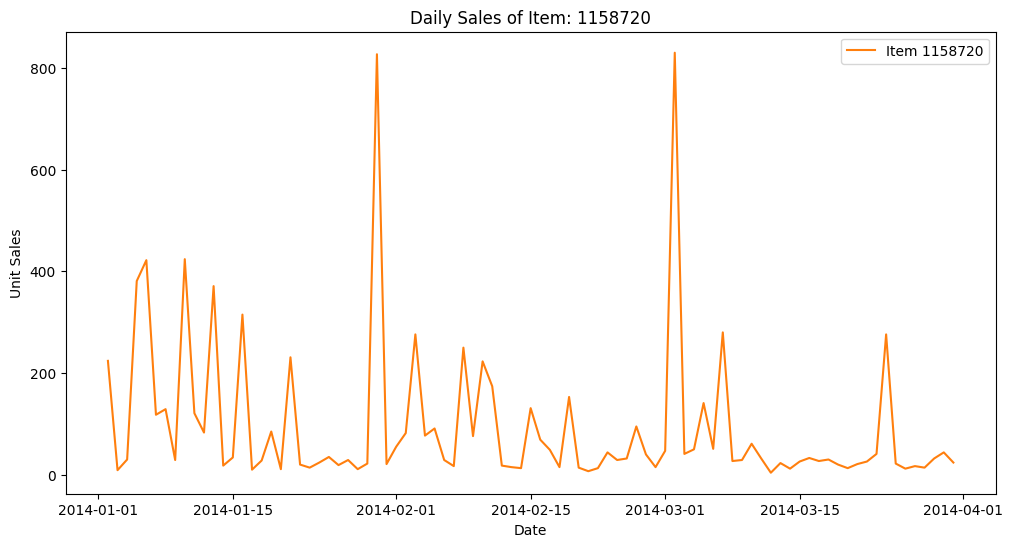

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Create a copy of the dataframe
df_copy = df.copy()

# Generate a colormap using the recommended method
colormap = plt.colormaps.get_cmap("tab10")  # No need for extra argument

# Iterate through unique item_nbr values
for idx, item_nbr in enumerate(df_copy['item_nbr'].unique()):
    df_item = df_copy[df_copy['item_nbr'] == item_nbr].copy()

    # Group by date and sum unit_sales
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()

    # Set 'date' as the index
    df_item.set_index('date', inplace=True)

    # Fill missing dates with zero sales
    df_item = df_item.asfreq('D').fillna(0)

    # Create a plot with a different color for each item
    plt.figure(figsize=(12, 6))
    plt.plot(df_item.index, df_item['unit_sales'], color=colormap(idx % 10), label=f'Item {item_nbr}')

    plt.title(f'Daily Sales of Item: {item_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()


In [10]:
df_copy.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable', 'outlier_flag', 'holiday_flag',
       'expanding_mean', 'lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2',
       'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7', 'dcoilwtico'],
      dtype='object')

In [11]:
#Numerical features
num_features = ['store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
        'perishable', 'outlier_flag', 'holiday_flag',
       'expanding_mean', 'lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2',
       'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7', 'dcoilwtico']
#Categorical features
cat_features = ['date','family', 'class']

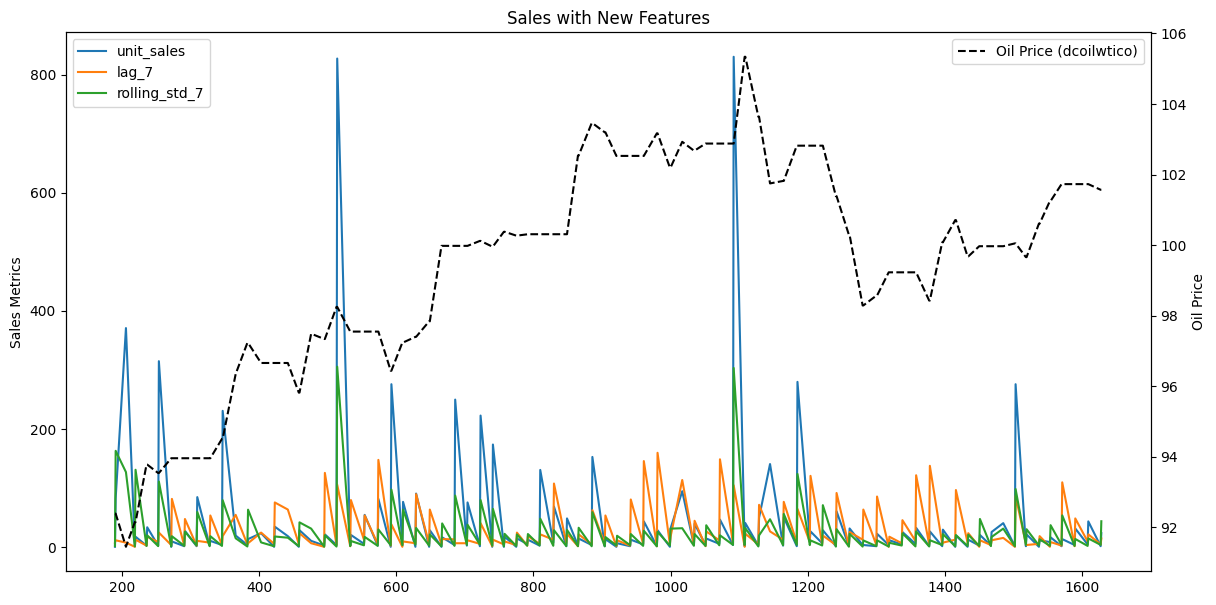

In [12]:
import matplotlib.pyplot as plt

# Drop any NaN values after creating rolling features
df_copy.dropna(inplace=True)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot sales-related features on the left y-axis
features = ['unit_sales', 'lag_7', 'rolling_std_7']
df_copy[features].plot(ax=ax1)
ax1.set_ylabel('Sales Metrics')
ax1.set_title('Sales with New Features')

# Create a second y-axis for oil prices
ax2 = ax1.twinx()
df_copy['dcoilwtico'].plot(ax=ax2, color='black', linestyle='dashed', label='Oil Price (dcoilwtico)')

# Label the right y-axis
ax2.set_ylabel('Oil Price')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


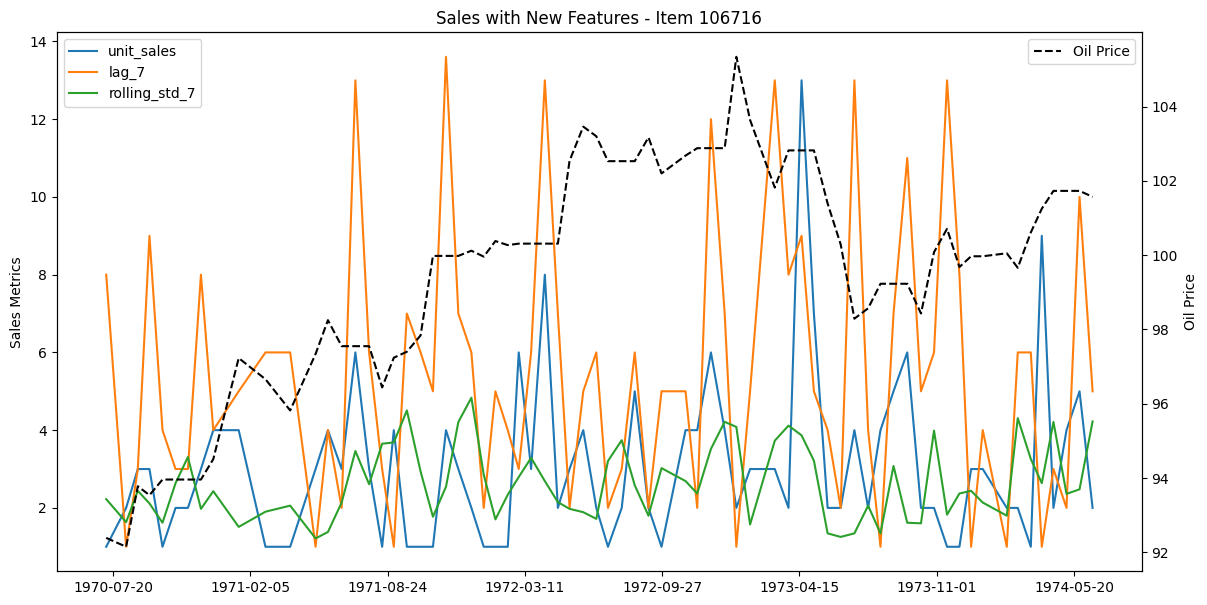

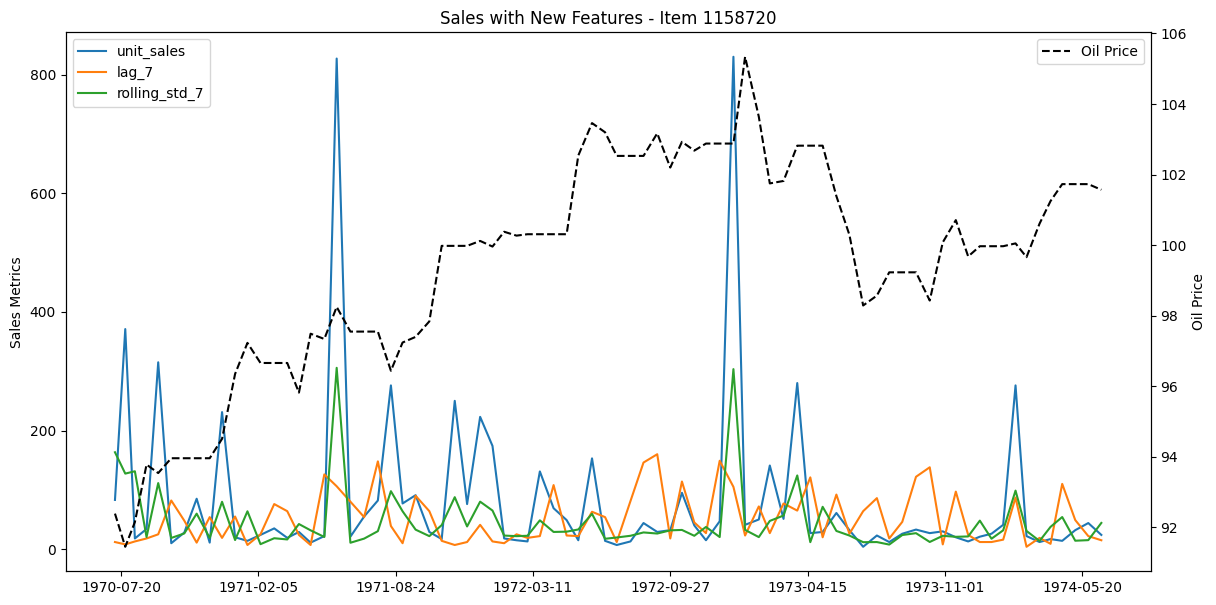

In [13]:
unique_items = df_copy['item_nbr'].unique()
for item_nbr in unique_items:
    df_item = df_copy[df_copy['item_nbr'] == item_nbr].copy()

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Ensure line plot instead of bars
    for feature in ['unit_sales', 'lag_7', 'rolling_std_7']:
        ax1.plot(df_item.index, df_item[feature], label=feature, linewidth=1.5)  # Adjust linewidth for smoothness

    ax1.set_ylabel('Sales Metrics')
    ax1.set_title(f'Sales with New Features - Item {item_nbr}')

    # Secondary y-axis for oil price
    ax2 = ax1.twinx()
    ax2.plot(df_item.index, df_item['dcoilwtico'], color='black', linestyle='dashed', linewidth=1.5, label='Oil Price')

    ax2.set_ylabel('Oil Price')

    # Format x-axis with dates
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()


## 2.2. Adding Date-based Features

In [14]:
import pandas as pd

# Ensure your index is a DatetimeIndex
df_copy = df_copy.set_index(pd.DatetimeIndex(df_copy['date']))


# Now you can extract date features
df_copy['day_of_week'] = df_copy.index.dayofweek  # 0 = Monday, 6 = Sunday
df_copy['month'] = df_copy.index.month
df_copy['is_weekend'] = df_copy['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
# Display the first few rows to verify
df_copy.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,...,lag_1,lag_2,lag_5,lag_10,lag_12,rolling_mean_7,dcoilwtico,day_of_week,month,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2014-01-12,17008479,2014-01-12,28,106716,1.0,0.0,GROCERY I,1032,0,0,...,6.0,4.0,8.0,4.0,7.0,3.571429,92.39,6,1,1
2014-01-12,17009522,2014-01-12,28,1158720,83.0,0.0,GROCERY I,1040,0,0,...,8.0,5.0,12.0,3.0,35.0,95.714286,92.39,6,1,1
2014-01-13,17075051,2014-01-13,28,1158720,371.0,0.0,GROCERY I,1040,0,0,...,13.0,65.0,8.0,27.0,10.0,89.000000,91.45,0,1,0
2014-01-14,17136849,2014-01-14,28,106716,2.0,0.0,GROCERY I,1032,0,0,...,1.0,3.0,1.0,1.0,3.0,3.000000,92.15,1,1,0
2014-01-14,17137712,2014-01-14,28,1158720,18.0,0.0,GROCERY I,1040,0,0,...,3.0,44.0,13.0,424.0,49.0,75.571429,92.15,1,1,0


## 2.3. Splitting Data into Training and Testing Sets

In [15]:
# %%
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df_copy is already defined and has been preprocessed in previous cells
# Define target variable (unit_sales) and features
df_filtered = df_copy.copy()

X = df_filtered.drop(['unit_sales','family'], axis=1)
y = df_filtered['unit_sales']

#Create X and y for each item
unique_items = df_filtered['item_nbr'].unique()
X_items = {}
y_items = {}

# Initialize dictionaries to store the train/test splits for each item
X_train_items = {}
X_test_items = {}
y_train_items = {}
y_test_items = {}

for item_nbr in unique_items:
    X_items[item_nbr] = df_filtered[df_filtered['item_nbr'] == item_nbr].drop(['unit_sales','family'], axis=1)
    y_items[item_nbr] = df_filtered[df_filtered['item_nbr'] == item_nbr]['unit_sales']
    # Split the data into training and testing sets named with item number (80% training, 20% testing)
    #Now we store each split into a dictionary that is assigned the name of the item as its key
    X_train_items[item_nbr], X_test_items[item_nbr], y_train_items[item_nbr], y_test_items[item_nbr] = train_test_split(X_items[item_nbr], y_items[item_nbr], test_size=0.2, shuffle=False)

    print(f"Item {item_nbr}:")
    #print the shape of the item in the dictionary
    print(f"X_train shape: {X_train_items[item_nbr].shape}")
    print(f"X_test shape: {X_test_items[item_nbr].shape}")

Item 106716:
X_train shape: (56, 23)
X_test shape: (15, 23)
Item 1158720:
X_train shape: (63, 23)
X_test shape: (16, 23)


## 2.4. Implementing XGBoost for Time-Series Forecasting

In [16]:
# Initialize the XGBoost regressor
xgboost_model_1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=15, learning_rate=0.01, subsample=1, colsample_bytree=0.7)

# Convert 'date' to numerical features before training
X_train_items[unique_items[0]]['date'] = pd.to_numeric(X_train_items[unique_items[0]]['date'])
X_test_items[unique_items[0]]['date'] = pd.to_numeric(X_test_items[unique_items[0]]['date'])

# Train the XGBoost model
xgboost_model_1.fit(X_train_items[unique_items[0]], y_train_items[unique_items[0]])

# Make predictions on the test set
y_pred_1 = xgboost_model_1.predict(X_test_items[unique_items[0]])

# Initialize the XGBoost regressor
xgboost_model_2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=15, learning_rate=0.01, subsample=1, colsample_bytree=0.7)

# Convert 'date' to numerical features before training
X_train_items[unique_items[1]]['date'] = pd.to_numeric(X_train_items[unique_items[1]]['date'])
X_test_items[unique_items[1]]['date'] = pd.to_numeric(X_test_items[unique_items[1]]['date'])

#Train the XGBoost model
xgboost_model_2.fit(X_train_items[unique_items[1]], y_train_items[unique_items[1]])

#Make predictions on the test set
y_pred_2 = xgboost_model_2.predict(X_test_items[unique_items[1]])

In [17]:
from sklearn.metrics import mean_absolute_error, explained_variance_score
#Evaluate model 1
mse_1 = mean_squared_error(y_test_items[unique_items[0]], y_pred_1)
print(f'Mean Squared Error (MSE) for Item {unique_items[0]}: {mse_1}')

rmse_1 = np.sqrt(mse_1)
print(f'Root Mean Squared Error (RMSE) for Item {unique_items[0]}: {rmse_1}')

r2_1 = xgboost_model_1.score(X_test_items[unique_items[0]], y_test_items[unique_items[0]])
print(f'R-squared (R2) Score for Item {unique_items[0]}: {r2_1}')

mae_1 = mean_absolute_error(y_test_items[unique_items[0]], y_pred_1)
print(f"Mean Absolute Error (MAE) for Item {unique_items[0]}: {mae_1}")

evs_1 = explained_variance_score(y_test_items[unique_items[0]], y_pred_1)
print(f"Explained Variance Score (EVS) for Item {unique_items[0]}: {evs_1}")

#Evaluate model 2
mse_2 = mean_squared_error(y_test_items[unique_items[1]], y_pred_2)
print(f'Mean Squared Error (MSE) for Item {unique_items[1]}: {mse_2}')

rmse_2 = np.sqrt(mse_2)
print(f'Root Mean Squared Error (RMSE) for Item {unique_items[1]}: {rmse_2}')

r2_2 = xgboost_model_2.score(X_test_items[unique_items[1]], y_test_items[unique_items[1]])

print(f'R-squared (R2) Score for Item {unique_items[1]}: {r2_2}')

mae_2 = mean_absolute_error(y_test_items[unique_items[1]], y_pred_2)
print(f"Mean Absolute Error (MAE) for Item {unique_items[1]}: {mae_2}")

evs_2 = explained_variance_score(y_test_items[unique_items[1]], y_pred_2)
print(f"Explained Variance Score (EVS) for Item {unique_items[1]}: {evs_2}")


Mean Squared Error (MSE) for Item 106716: 9.13758939997916
Root Mean Squared Error (RMSE) for Item 106716: 3.022844587467103
R-squared (R2) Score for Item 106716: -1.015644720583638
Mean Absolute Error (MAE) for Item 106716: 2.595067024230957
Explained Variance Score (EVS) for Item 106716: -0.5130582372098762
Mean Squared Error (MSE) for Item 1158720: 809.5991867402919
Root Mean Squared Error (RMSE) for Item 1158720: 28.4534564989966
R-squared (R2) Score for Item 1158720: 0.7853995764034564
Mean Absolute Error (MAE) for Item 1158720: 22.217890504896225
Explained Variance Score (EVS) for Item 1158720: 0.8503746232672607


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

grid_search_1 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           scoring='neg_mean_squared_error',  # Optimize for MSE
                           n_jobs=-1,  # Use all cores
                           verbose=1)

grid_search_1.fit(X_train_items[unique_items[0]], y_train_items[unique_items[0]])

# Get the best parameters
best_params_1 = grid_search_1.best_params_
print(f"Best parameters for Model 1: {best_params_1}")

# Use the best model
best_model_1 = grid_search_1.best_estimator_


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Model 1: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Model 1: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

grid_search_2 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           scoring='neg_mean_squared_error',  # Optimize for MSE
                           n_jobs=-1,  # Use all cores
                           verbose=1)

grid_search_2.fit(X_train_items[unique_items[1]], y_train_items[unique_items[1]])

# Get the best parameters
best_params_2 = grid_search_2.best_params_
print(f"Best parameters for Model 2: {best_params_2}")

# Use the best model
best_model_2 = grid_search_2.best_estimator_





Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Model 2: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Model 2: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

In [20]:
#Model 1
xgboost_model_1 = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 max_depth=6,
                                 learning_rate=0.1,
                                   colsample_bytree=0.7,
                                   subsample=0.8,
                                 alpha=0.1   # L1 regularization
                                 ) # L2 regularization

# Train the XGBoost model
xgboost_model_1.fit(X_train_items[unique_items[0]], y_train_items[unique_items[0]])

# Make predictions on the test set
y_pred_1 = xgboost_model_1.predict(X_test_items[unique_items[0]])

#Model 2
xgboost_model_2 = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=200,
                                 max_depth=6,
                                 learning_rate=0.2,
                                   colsample_bytree=0.7,
                                   subsample=1.0,
                                   alpha=0.1   # L1 regularization
      )
                                 # Train the XGBoost model
xgboost_model_2.fit(X_train_items[unique_items[1]], y_train_items[unique_items[1]])

# Make predictions on the test set
y_pred_2 = xgboost_model_2.predict(X_test_items[unique_items[1]])





In [21]:
from sklearn.metrics import mean_absolute_error, explained_variance_score
#Evaluate model 1
mse_1 = mean_squared_error(y_test_items[unique_items[0]], y_pred_1)
print(f'Mean Squared Error (MSE) for Item {unique_items[0]}: {mse_1}')

rmse_1 = np.sqrt(mse_1)
print(f'Root Mean Squared Error (RMSE) for Item {unique_items[0]}: {rmse_1}')

r2_1 = xgboost_model_1.score(X_test_items[unique_items[0]], y_test_items[unique_items[0]])
print(f'R-squared (R2) Score for Item {unique_items[0]}: {r2_1}')

mae_1 = mean_absolute_error(y_test_items[unique_items[0]], y_pred_1)
print(f"Mean Absolute Error (MAE) for Item {unique_items[0]}: {mae_1}")

evs_1 = explained_variance_score(y_test_items[unique_items[0]], y_pred_1)
print(f"Explained Variance Score (EVS) for Item {unique_items[0]}: {evs_1}")

#Evaluate model 2
mse_2 = mean_squared_error(y_test_items[unique_items[1]], y_pred_2)
print(f'Mean Squared Error (MSE) for Item {unique_items[1]}: {mse_2}')

rmse_2 = np.sqrt(mse_2)
print(f'Root Mean Squared Error (RMSE) for Item {unique_items[1]}: {rmse_2}')

r2_2 = xgboost_model_2.score(X_test_items[unique_items[1]], y_test_items[unique_items[1]])

print(f'R-squared (R2) Score for Item {unique_items[1]}: {r2_2}')

mae_2 = mean_absolute_error(y_test_items[unique_items[1]], y_pred_2)
print(f"Mean Absolute Error (MAE) for Item {unique_items[1]}: {mae_2}")

evs_2 = explained_variance_score(y_test_items[unique_items[1]], y_pred_2)
print(f"Explained Variance Score (EVS) for Item {unique_items[1]}: {evs_2}")


Mean Squared Error (MSE) for Item 106716: 12.434953765487144
Root Mean Squared Error (RMSE) for Item 106716: 3.5263229808806713
R-squared (R2) Score for Item 106716: -1.7430045070927527
Mean Absolute Error (MAE) for Item 106716: 3.177555863062541
Explained Variance Score (EVS) for Item 106716: -0.47234738753014005
Mean Squared Error (MSE) for Item 1158720: 1866.596785337522
Root Mean Squared Error (RMSE) for Item 1158720: 43.204129262577695
R-squared (R2) Score for Item 1158720: 0.5052212658090567
Mean Absolute Error (MAE) for Item 1158720: 28.964604620039047
Explained Variance Score (EVS) for Item 1158720: 0.5206767708763091


## 2.4. Plotting Actual vs Predicted Values

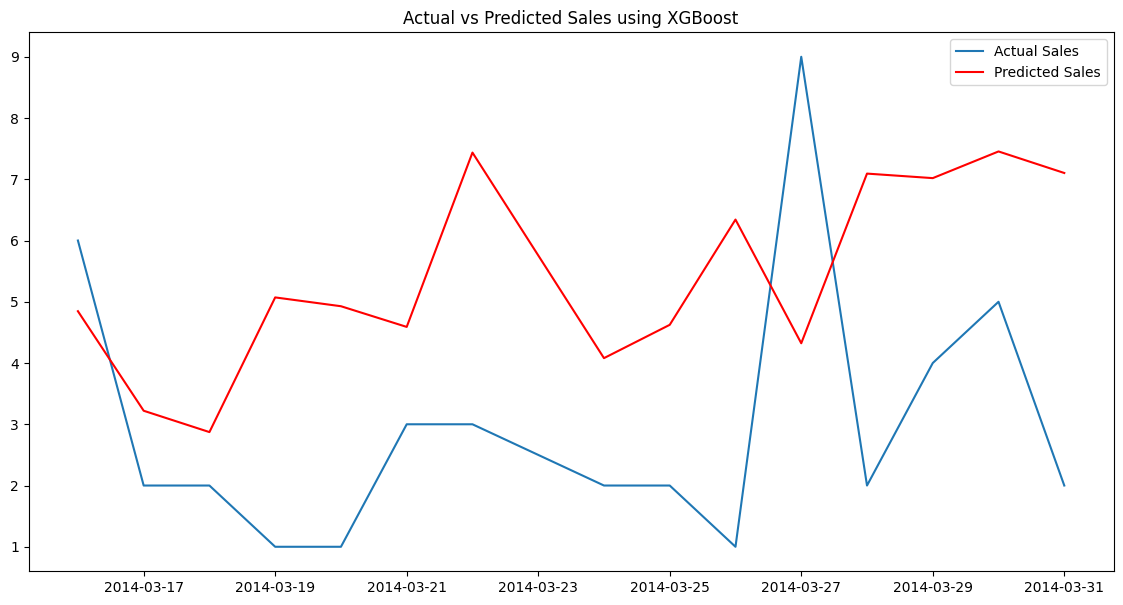

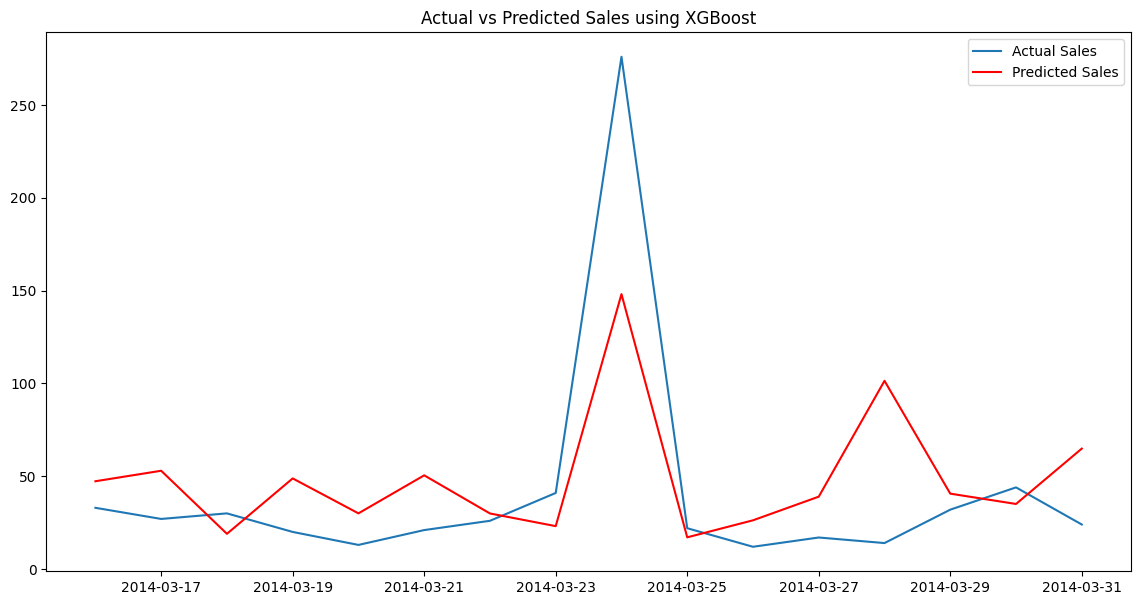

In [22]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_items[unique_items[0]].index, y_test_items[unique_items[0]].values, label='Actual Sales')
plt.plot(y_test_items[unique_items[0]].index, y_pred_1, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_items[unique_items[1]].index, y_test_items[unique_items[1]].values, label='Actual Sales')
plt.plot(y_test_items[unique_items[1]].index, y_pred_2, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()



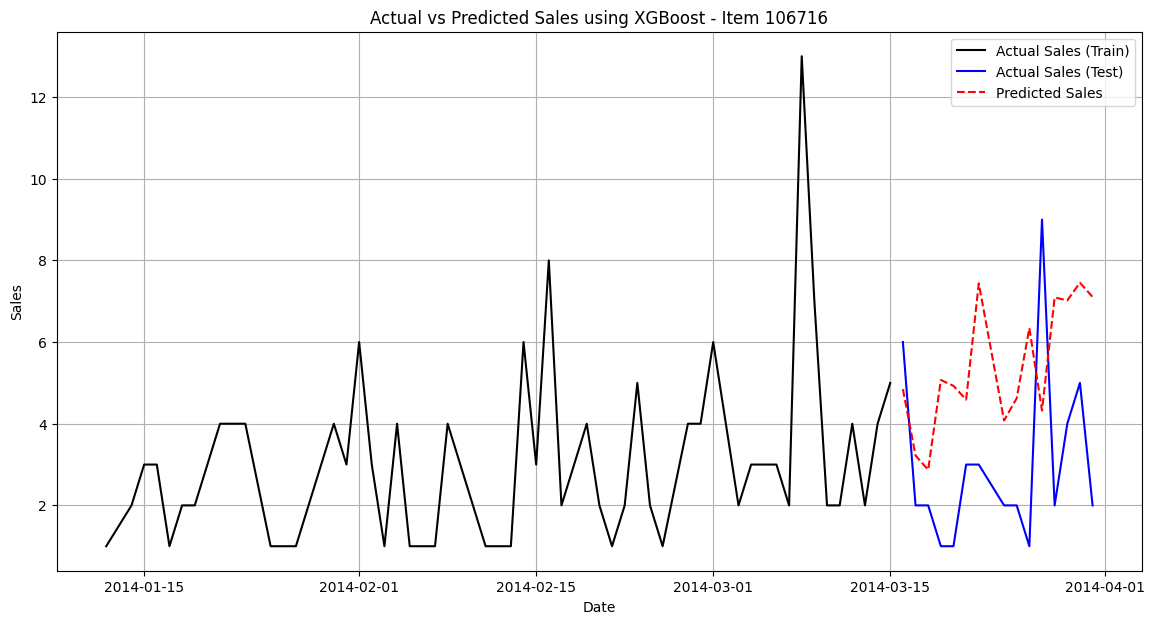

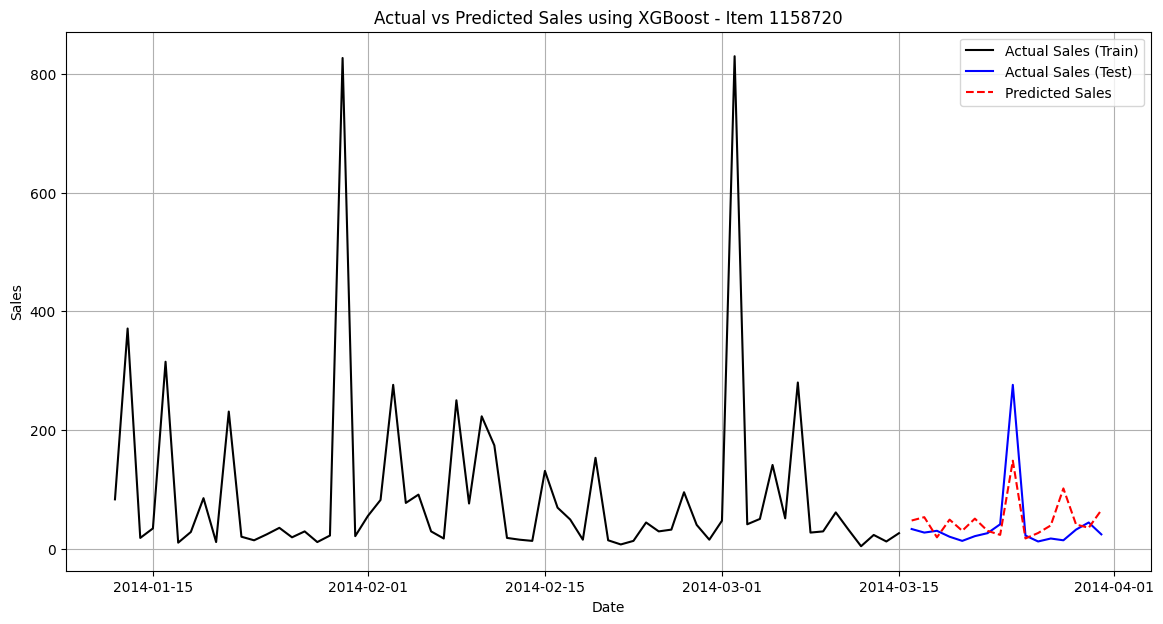

In [29]:
import matplotlib.pyplot as plt

# ✅ Plot Actual vs Predicted Sales for Item 1 (Full Dataset)
plt.figure(figsize=(14, 7))
plt.plot(y_train_items[unique_items[0]].index, y_train_items[unique_items[0]].values, label="Actual Sales (Train)", color="black")
plt.plot(y_test_items[unique_items[0]].index, y_test_items[unique_items[0]].values, label="Actual Sales (Test)", color="blue")
plt.plot(y_test_items[unique_items[0]].index, y_pred_1, label="Predicted Sales", color="red", linestyle="dashed")

plt.title(f"Actual vs Predicted Sales using XGBoost - Item {unique_items[0]}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Plot Actual vs Predicted Sales for Item 2 (Full Dataset)
plt.figure(figsize=(14, 7))
plt.plot(y_train_items[unique_items[1]].index, y_train_items[unique_items[1]].values, label="Actual Sales (Train)", color="black")
plt.plot(y_test_items[unique_items[1]].index, y_test_items[unique_items[1]].values, label="Actual Sales (Test)", color="blue")
plt.plot(y_test_items[unique_items[1]].index, y_pred_2, label="Predicted Sales", color="red", linestyle="dashed")

plt.title(f"Actual vs Predicted Sales using XGBoost - Item {unique_items[1]}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
import joblib

# Define paths to save models
model_1_path = "xgboost_model_stor_1.pkl"
model_2_path = "xgboost_model_stor_2.pkl"

# Save models using joblib
joblib.dump(xgboost_model_1, model_1_path)
joblib.dump(xgboost_model_2, model_2_path)

print(f"Model 1 saved to: {model_1_path}")
print(f"Model 2 saved to: {model_2_path}")

# To load the models back
loaded_xgb_model_1 = joblib.load(model_1_path)
loaded_xgb_model_2 = joblib.load(model_2_path)

print("Models successfully loaded!")


Model 1 saved to: xgboost_model_stor_1.pkl
Model 2 saved to: xgboost_model_stor_2.pkl
Models successfully loaded!


# Conclusions

✔ This method is valid for time series forecasting with XGBoost.
✔ It uses lags, scaling, and confidence intervals, which are essential for robust predictions.
✔ It is commonly used in real-world sales forecasting when complex seasonality effects are not dominant.

⚠ However, there are some limitations:

XGBoost does not inherently model time-based dependencies, meaning methods like ARIMA, LSTM, or Prophet could provide better results for certain datasets.
There is no explicit seasonality modeling, which may reduce accuracy if seasonality is significant.
Manual scaling may not always be correct, though it can work well for stable data.

If the data has strong seasonality or trend shifts, specialized time series models (e.g., ARIMA, Prophet, LSTM) are recommended.

# NEXT Model LSTM here: One_Store_two_items_Guayas_LSTM_model https://colab.research.google.com/drive/1Qlt6SbMYdMMb8q0XRa_9MA2YQ0i4O6wl?usp=sharing

Predictions without corrections: